In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from knn import KNNCalibrator

## EXAMPLE 1
# --- Paraboloid model (vectorized) ---
def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5, noise=True):
    """ Simple quadratic paraboloid with optional Gaussian noise. Works for one or many θ samples. """
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:  # scalar
        xi = np.full(theta.shape[0], xi)
    y = A * x1 ** 2 + B * x1 * x2 + C * (x2 + xi) ** 2
    if noise:
        y = y + 3*np.random.randn(theta.shape[0])
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])

# --- θ sampler --- (thi could be a prior)
def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))



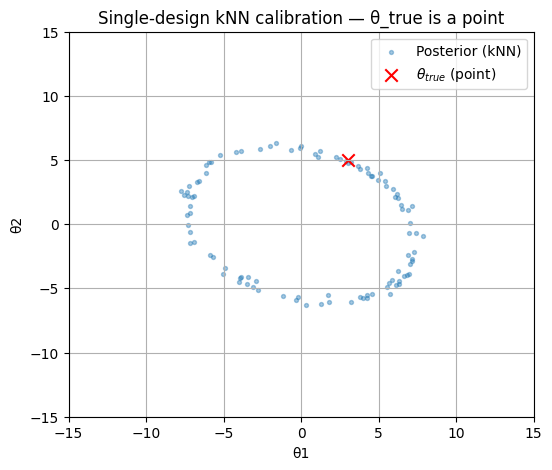

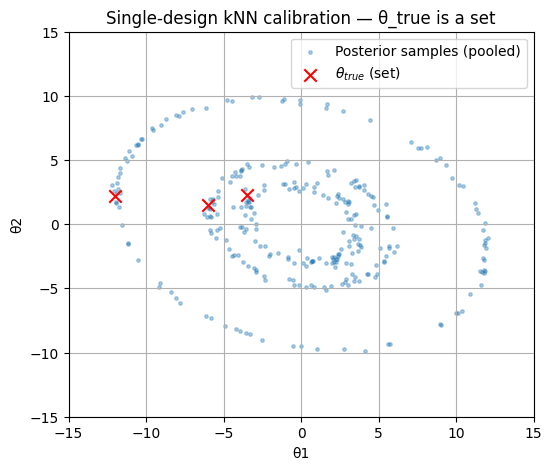

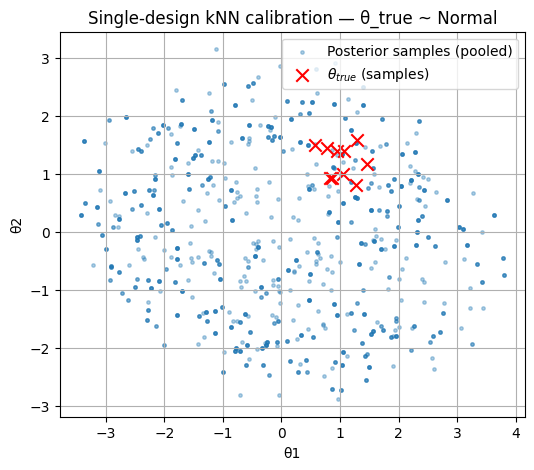

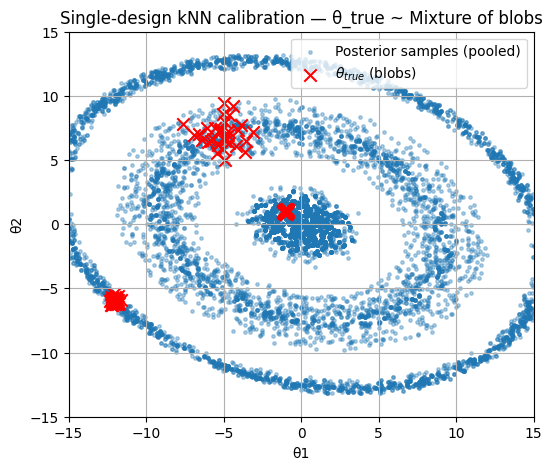

In [66]:
## EXAMPLE 1
# Simulate a dataset
N_SIM, xi_baseline = 25000, 0.0
theta_sim = theta_sampler(N_SIM)
xi_sim = np.zeros((N_SIM, 1))  # single design
y_sim = np.vstack([paraboloid_model(theta=th, xi=xi_baseline) for th in theta_sim])

simulated_data = {"y": y_sim, "theta": theta_sim, "xi": xi_sim}

# 1.1) θ_true is a single point
theta_true_point = np.array([np.random.randint(20) - 10, np.random.randint(20) - 10])
y_obs_point = paraboloid_model(theta_true_point).reshape(1, -1)

calib = KNNCalibrator(knn=100)
calib.setup(simulated_data=simulated_data, xi_list=[xi_baseline])  # single-design mode
theta_post_point = calib.calibrate([(y_obs_point, xi_baseline)])

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_point[:, 0], theta_post_point[:, 1],
            s=8, alpha=0.4, label="Posterior (kNN)")
plt.scatter(theta_true_point[0], theta_true_point[1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (point)")
plt.title("Single-design kNN calibration — θ_true is a point")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.legend()
plt.grid(True)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()

# 1.2) θ_true are multiple points (repeated experiments with varying θ)
theta_true_set = np.array([    [-6.0, 1.5],
                               [-3.5, 2.3],
                               [-12.0, 2.2],])

y_obs_many = paraboloid_model(theta_true_set)  # 3 rows → 3 observations

theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled kNN matches

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_set[:, 0], theta_true_set[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (set)")
plt.title("Single-design kNN calibration — θ_true is a set")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.legend()
plt.grid(True)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()


# 1.3) θ_true ~ Normal(1.2, 0.3)
theta_true_sam = np.random.normal(1.2, 0.3, size=(10, 2))
y_obs_many = paraboloid_model(theta_true_sam)

theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled calibration

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_sam[:, 0], theta_true_sam[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (samples)")
plt.title("Single-design kNN calibration — θ_true ~ Normal")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.show()


# 1.4) θ_true ~ Mixture of blobs
theta_true_sam, _ = make_blobs(  n_samples=100,   centers=[(-1., 1.), (-5., 7.), (-12., -6.)], cluster_std=(0.1, 1.0, 0.2),  random_state=42 )
y_obs_many = paraboloid_model(theta_true_sam)
theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled calibration
plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_sam[:, 0], theta_true_sam[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (blobs)")
plt.title("Single-design kNN calibration — θ_true ~ Mixture of blobs")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.xlim([-15, 15]); plt.ylim([-15, 15]); plt.show()


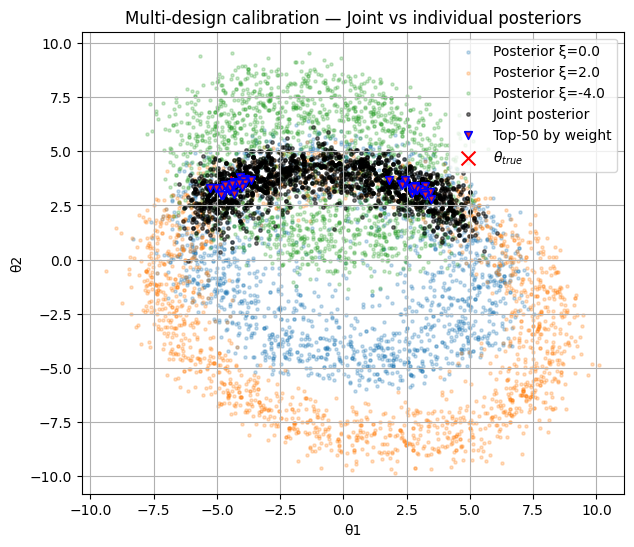

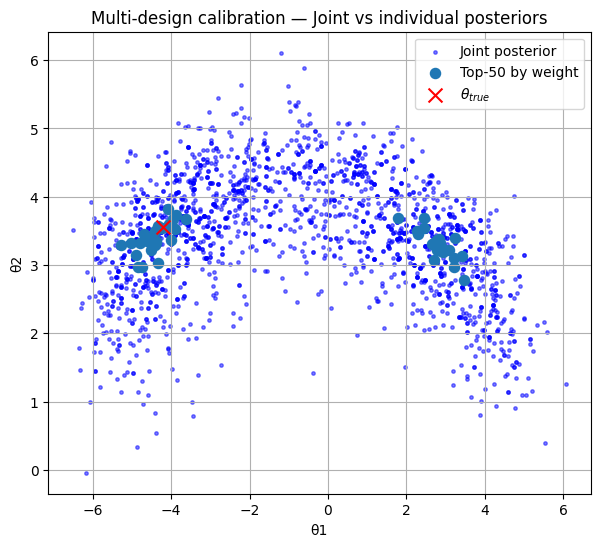

In [70]:
## EXAMPLE 1 -  True θ (single point) + multi design (3 control)
theta_true = np.array([-4.2, 3.55])

# Three control design points
xi1, xi2, xi3 = 0.0, 2.0, -4.0

top_k = 50 # show 50 most likely simulation
n_post_samples = 2000

# Generate observations at each design
rng = np.random.default_rng(42)
y_obs_xi1 = paraboloid_model(theta_true, xi1)
y_obs_xi2 = paraboloid_model(theta_true, xi2)
y_obs_xi3 = paraboloid_model(theta_true, xi3)

# Setup joint calibrator
calib_joint = KNNCalibrator(kernel_bandwidth=None)
calib_joint.setup(model=paraboloid_model,
                  theta_sampler=theta_sampler,
                  xi_list=[xi1, xi2, xi3],
                  n_samples=100000)

# Fuse all datasets (joint posterior)
observations = [(y_obs_xi1, xi1), (y_obs_xi2, xi2), (y_obs_xi3, xi3)]
theta_grid, weights = calib_joint.calibrate(observations, resample_n=None)
theta_post_joint, _ = calib_joint.calibrate(observations, resample_n=n_post_samples)


idx_top = np.argpartition(weights, -top_k)[-top_k:]
idx_top = idx_top[np.argsort(weights[idx_top])[::-1]]  # descending by weight
# Individual per-design posteriors

theta_post_xi1, _ = calib_joint.calibrate([(y_obs_xi1, xi1)], resample_n=n_post_samples)
theta_post_xi2, _ = calib_joint.calibrate([(y_obs_xi2, xi2)], resample_n=n_post_samples)
theta_post_xi3, _ = calib_joint.calibrate([(y_obs_xi3, xi3)], resample_n=n_post_samples)

# Plot: joint vs individual
plt.figure(figsize=(7, 6))
plt.scatter(theta_post_xi1[:, 0], theta_post_xi1[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi1}")
plt.scatter(theta_post_xi2[:, 0], theta_post_xi2[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi2}")
plt.scatter(theta_post_xi3[:, 0], theta_post_xi3[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi3}")
plt.scatter(theta_post_joint[:, 0], theta_post_joint[:, 1], s=6, alpha=0.5, c="k", label="Joint posterior")

plt.scatter(theta_grid[idx_top, 0], theta_grid[idx_top, 1], s=30, marker='v', edgecolors='b',
           linewidths=1.2, zorder=6, label=f"Top-{top_k} by weight")
plt.scatter(theta_true[0], theta_true[1], c="r", marker="x", s=100, label=r"$θ_{true}$")
plt.title("Multi-design calibration — Joint vs individual posteriors")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.show()

# Plot: joint vs individual
plt.figure(figsize=(7, 6))
plt.scatter(theta_post_joint[:, 0], theta_post_joint[:, 1], s=6, alpha=0.5, c="b", label="Joint posterior")
plt.scatter(theta_grid[idx_top, 0], theta_grid[idx_top, 1], s=50, linewidths=1.2, label= f"Top-{top_k} by weight")
plt.scatter(theta_true[0], theta_true[1], c="r", marker="x", s=100, label=r"$θ_{true}$")
plt.title("Multi-design calibration — Joint vs individual posteriors")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.show()

In [102]:
# EX 3 - NASA-like
import numpy as np

# --- NASA-like synthetic model: θ = [xa1, xa2, xe1, xe2, xe3], xi ∈ R^3 → y ∈ R^6 ---
def nasa_synthetic_model(theta, xi=None, noise=True):
    """
    Vectorized toy model with NASA-like dimensions:
      theta: (n,5) or (5,)    -> [xa1, xa2, xe1, xe2, xe3]
      xi:    (n,3) or (3,)    -> [xc1, xc2, xc3]
      returns y: (n,6) or (6,)
    """
    theta = np.atleast_2d(theta).astype(float)
    n = theta.shape[0]
    xa1, xa2, xe1, xe2, xe3 = theta.T

    if xi is None:
        xi = np.zeros((n, 3))
    else:
        xi = np.atleast_2d(xi).astype(float)
        if xi.shape[0] == 1 and n > 1:  # broadcast one design to all theta
            xi = np.repeat(xi, n, axis=0)
    xc1, xc2, xc3 = xi.T

    # 6 KPIs (nonlinear & mixed terms)
    y1 = xa1**2 + xe1 + np.sin(xc1)
    y2 = xa2 * xe2 + np.cos(xc2)
    y3 = xe3**2 - xa1*xa2 + np.tanh(xc3)
    y4 = xa1 + xa2 + xe1*xe2
    y5 = np.exp(-0.1*(xe2+xc1)) + xa1*xc2
    y6 = np.log1p(np.abs(xa2+xe3)) + xc3
    Y = np.column_stack([y1, y2, y3, y4, y5, y6])

    if noise:
        Y += 0.05 * np.random.randn(*Y.shape)

    return Y if n > 1 else Y[0]

# -------------------- DATA GENERATION --------------------

rng = np.random.default_rng(123)

# 1) Build 100 θ-samples: first two (xa) from a distribution, last three (xe) fixed
ns = 100
xe_true = np.array([3.1, 2.3, -4])               # fixed epistemic part (xe)
xa_samples = rng.normal(loc=[1.3, 1.1], scale=[0.02, 0.2], size=(ns, 2))  # choose any distribution you like
xa_samples = np.clip(xa_samples, 0 , 1)
theta_samples = np.hstack([xa_samples, np.tile(xe_true, (ns, 1))])      # shape (100, 5)

# 2) Ten designs (xi_list ∈ R^{10×3}); choose any set you like (here: uniform box)
xi_list = rng.uniform(low=0.1, high=0.9, size=(10, 3))                  # shape (10, 3)

# 3) For each design, generate a dataset of 100 observations (6 KPIs each)
#    This mirrors the challenge: different aleatoric θ (xa) per observation, same xe fixed, 10 designs.
datasets = []  # list of tuples [(Y^(1), xi_1), ..., (Y^(10), xi_10)]
for xi in xi_list:
    Y = nasa_synthetic_model(theta_samples, xi, noise=True)              # shape (100, 6)
    datasets.append((Y, xi))

# Optional: stack into a single array for convenience → shape (10, 100, 6)
y_obs_stack = np.stack([Y for (Y, _) in datasets], axis=0)

# -------------------- QUICK INSPECTION --------------------
print("theta_samples shape:", theta_samples.shape)  # (100, 5)
print("xi_list shape:", xi_list.shape)              # (10, 3)
print("y_obs_stack shape:", y_obs_stack.shape)      # (10, 100, 6)

# Show a small preview: first design, first 5 observations
print("\nFirst and second design xi:", (datasets[0][1], datasets[1][1]))
print("First 5 observations (6 KPIs each):\n", datasets[0][0][:5])

def theta_sampler_nasa(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 5))


theta_samples shape: (100, 5)
xi_list shape: (10, 3)
y_obs_stack shape: (10, 100, 6)

First and second design xi: (array([0.34774879, 0.24160872, 0.31442463]), array([0.7818835 , 0.89525782, 0.3965394 ]))
First 5 observations (6 KPIs each):
 [[ 4.44863133  3.19777844 15.3334459   9.16921159  1.02343416  1.73938509]
 [ 4.41306611  3.27664611 15.41605537  9.20286332  1.02543882  1.69664406]
 [ 4.4877892   3.1863306  15.28619924  9.09738687  1.01119293  1.64690913]
 [ 4.48485496  3.24447567 15.30582357  9.08391122  1.02945831  1.71615755]
 [ 4.40327133  3.24709794 15.29943164  9.08958892  1.0189868   1.76287817]]


In [103]:
# We build one calibrator per design; each uses xi_sampler fixed at that design.
def make_const_xi_sampler(xi):
    xi = np.asarray(xi, float).ravel()
    return lambda n, xi=xi: np.repeat(xi[None, :], n, axis=0)


[Design 00] xi=[0.348 0.242 0.314] | posterior mean xe ≈ [-0.754  0.02  -0.543]| True xe = [ 3.1  2.3 -4. ]
[Design 01] xi=[0.782 0.895 0.397] | posterior mean xe ≈ [-0.029 -0.122 -0.311]| True xe = [ 3.1  2.3 -4. ]
[Design 02] xi=[0.469 0.368 0.392] | posterior mean xe ≈ [0.624 0.198 0.368]| True xe = [ 3.1  2.3 -4. ]
[Design 03] xi=[0.65  0.688 0.354] | posterior mean xe ≈ [-1.068  0.388 -1.429]| True xe = [ 3.1  2.3 -4. ]
[Design 04] xi=[0.216 0.666 0.452] | posterior mean xe ≈ [-1.508 -0.412 -0.119]| True xe = [ 3.1  2.3 -4. ]
[Design 05] xi=[0.833 0.427 0.122] | posterior mean xe ≈ [-0.308  0.135 -0.207]| True xe = [ 3.1  2.3 -4. ]
[Design 06] xi=[0.681 0.889 0.473] | posterior mean xe ≈ [ 0.925 -0.256 -0.386]| True xe = [ 3.1  2.3 -4. ]
[Design 07] xi=[0.862 0.23  0.27 ] | posterior mean xe ≈ [-1.589  0.383 -0.167]| True xe = [ 3.1  2.3 -4. ]
[Design 08] xi=[0.373 0.425 0.82 ] | posterior mean xe ≈ [-0.052  1.035 -0.008]| True xe = [ 3.1  2.3 -4. ]
[Design 09] xi=[0.878 0.508 0.6

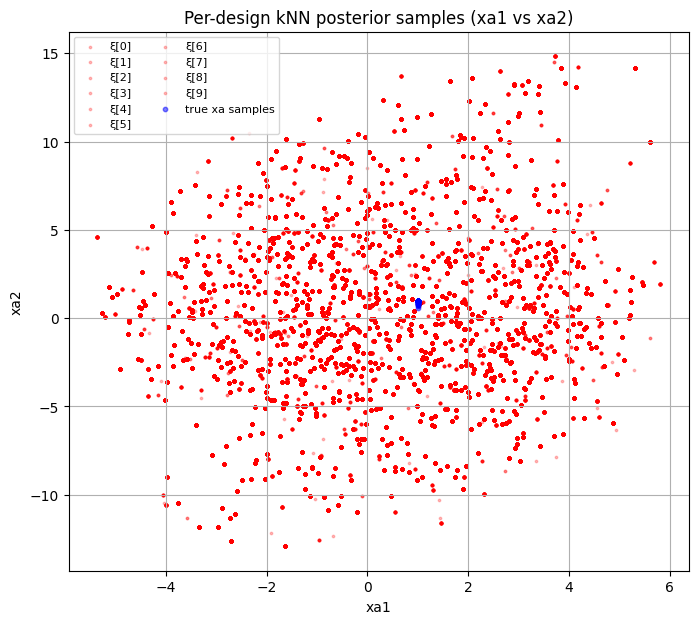

Posterior xe mean (all designs): [-0.41160043  0.1241488  -0.37641215]
True xe: [0.1  0.3  0.14]


In [104]:

# ---------- CALIBRATION (per-design single kNN) ----------

posterior_by_design = []
N_SIM = 10000  # number of simulator runs per design for the kNN atlas
K = 100         # neighbors per observation

for di, (Y_obs, xi) in enumerate(datasets):
    calib = KNNCalibrator(knn=K)
    xi_sampler = make_const_xi_sampler(xi)  # ensure simulations are at THIS xi
    calib.setup(model=nasa_synthetic_model,
                theta_sampler=theta_sampler_nasa,
                xi_sampler=xi_sampler,
                xi_list=[xi],              # SINGLE-DESIGN mode
                n_samples=N_SIM)

    # Calibrate with all 100 obs for this design (pooled)
    theta_post = calib.calibrate([(Y_obs, xi)])      # shape: (100*K, 5)
    posterior_by_design.append(theta_post)

    # Quick summary for xe (should concentrate near xe_fixed)
    xe_mean = theta_post[:, 2:5].mean(axis=0)
    print(f"[Design {di:02d}] xi={np.round(xi,3)} | posterior mean xe ≈ {np.round(xe_mean,3)}| True xe = {np.round(xe_true,3)}")

# ---------- PLOTS ----------
# 1) Overlay of posterior (xa1, xa2) by design
plt.figure(figsize=(8, 7))
for i, th in enumerate(posterior_by_design):
    plt.scatter(th[:, 0], th[:, 1], s=3, alpha=0.25, c='r', label=f"ξ[{i}]")
plt.scatter(theta_samples[:, 0], theta_samples[:, 1], c="b", s=10, alpha=0.5, label="true xa samples")
plt.title("Per-design kNN posterior samples (xa1 vs xa2)")
plt.xlabel("xa1"); plt.ylabel("xa2"); plt.grid(True); plt.legend(ncol=2, fontsize=8)
plt.show()

# 2) Distribution of posterior xe (should be tight near xe_fixed)
all_theta_post = np.vstack(posterior_by_design)   # (10*100*K, 5)
xe_post = all_theta_post[:, 2:5]
print("Posterior xe mean (all designs):", xe_post.mean(axis=0))
print("True xe:", xe_fixed)